# Data Preprocessing

In [30]:
import csv
import sqlite3
import numpy as np
from collections import defaultdict

LABEL_O_MAX_SIZE = 35000

# Define the function for parsing float values from CSV cells
def parse_float(value):
    if value:
        if value == "0,0" or value == "0":
            return None  # Mark as None to handle later
        else:
            if ',' in value and '.' not in value:
                value = value.replace(',', '.')
                
            try:
                return float(value)
            except ValueError:
                return None  # If conversion fails, mark as None
    else:
        return None  # Handle missing values as appropriate

def round_sig(x, sig=4):
    """Round a number to a specified number of significant digits."""
    if x == 0:
        return 0.0
    else:
        return float('{:.{p}g}'.format(x, p=sig))

# Step 1: Read the CSV file and collect data for mean calculation per label
column_data_per_label = defaultdict(lambda: defaultdict(list))
table_name = "energy_records"

# Read the CSV to calculate column means grouped by label
with open('/kaggle/input/multiclassfication/gennaio2023_kmeans.csv', "r", newline='', encoding='latin1') as csvfile:
    reader = csv.DictReader(csvfile, delimiter=';')
    for row in reader:
        label = row['LABEL']  # Get the label for each row
        for col in ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'A07', 'A08', 'A09', 'A10',
                    'A11', 'A12', 'A13', 'A14', 'A15', 'A16', 'A17', 'A18', 'A19', 'A20',
                    'A21', 'A22', 'A23', 'A24']:
            value = parse_float(row[col])
            if value is not None:  # Only consider non-zero, valid values for mean calculation
                column_data_per_label[label][col].append(value)

# Calculate means, ignoring zeroes and handling empty lists, for each label
column_means_per_label = {
    label: {
        col: np.mean(values) if values else 0
        for col, values in columns.items()
    }
    for label, columns in column_data_per_label.items()
}

# Round the column means to 4 significant digits
for label in column_means_per_label:
    for col in column_means_per_label[label]:
        column_means_per_label[label][col] = round_sig(column_means_per_label[label][col])

# Step 2: Create and populate the SQLite database using the means per label
#con = sqlite3.connect("res/records.db")
# cur = con.cursor()
#cur.execute('DROP TABLE IF EXISTS energy_records')
# cur.execute('''
#     CREATE TABLE IF NOT EXISTS energy_records (
#         pod_id TEXT, a01 REAL, a02 REAL, a03 REAL, a04 REAL, a05 REAL, a06 REAL,
#         a07 REAL, a08 REAL, a09 REAL, a10 REAL, a11 REAL, a12 REAL, a13 REAL,
#         a14 REAL, a15 REAL, a16 REAL, a17 REAL, a18 REAL, a19 REAL, a20 REAL,
#         a21 REAL, a22 REAL, a23 REAL, a24 REAL, label TEXT, used_training INTEGER
#     )
# ''')

whitelist = ['pod_id', 'A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'A07', 'A08', 'A09', 'A10',
             'A11', 'A12', 'A13', 'A14', 'A15', 'A16', 'A17', 'A18', 'A19', 'A20', 'A21',
             'A22', 'A23', 'A24', 'LABEL']
batch_size = 50000
batch = []
count_0 = 0

# Open the output CSV file to save a copy of the data inserted into the database
with open('/kaggle/input/multiclassfication/gennaio2023_kmeans.csv', "r", newline='', encoding='latin1', errors='replace') as csvfile_in, \
     open('/kaggle/working/processed_data.csv', 'w', newline='', encoding='utf-8') as csvfile_out:

    reader = csv.DictReader(csvfile_in, delimiter=';')
    writer = csv.writer(csvfile_out)
    # Write the header to the output CSV file
    writer.writerow(whitelist + ['used_training'])

    for i, row in enumerate(reader, start=1):
        try:
            values = []
            exec = True
            label = row['LABEL']  # Get the label for this specific row
            if label == "0":
                count_0 += 1
            if label == "0" and count_0 > LABEL_O_MAX_SIZE:
                exec = False

            if exec:
                for col in whitelist:
                    if col != 'LABEL' and col != 'pod_id':
                        value = parse_float(row[col])
                        # Replace zeroes with the mean of the column specific to this label
                        if value is None or value == 0.0:
                            value = column_means_per_label[label][col]  # Replace with column mean for the specific label
                        # Round value to 4 significant digits
                        if isinstance(value, float):
                            value = round_sig(value, sig=4)
                        values.append(value)
                    else:
                        values.append(row[col])

                batch.append(values)
                # Also write to the output CSV file
                writer.writerow(values + [0])  # Append 'used_training' value (0)

            # if len(batch) >= batch_size:
            #     cur.executemany("INSERT INTO energy_records VALUES(?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, 0)", batch)
            #     con.commit()
            #     batch = []  # Clear the batch after committing
            #     print(f"DB insertion progress: {i}")
        except ValueError as e:
            print(f"ValueError: {e} in row {reader.line_num}")
            continue  # Handle or skip rows with invalid data

# Insert remaining records in the last batch
# if batch:
#     cur.executemany("INSERT INTO energy_records VALUES(?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, 0)", batch)
#     con.commit()

print("Data insertion complete.")
# con.close().


Data insertion complete.


In [10]:
pip install states

  Preparing metadata (setup.py) ... done
  Created wheel for states: filename=states-0.2.1-py3-none-any.whl size=10783 sha256=d22c5a0861a6e768f69f5caf80c808a930226b6363b3315e32faee068a756378
  Stored in directory: /root/.cache/pip/wheels/49/e5/12/ce52c9ce335ab279c5d614f836f049265e8bef955766501604
Successfully built states
Note: you may need to restart the kernel to use updated packages.


In [5]:
pip install db

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.0/172.0 kB 5.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for db: filename=db-0.1.1-py3-none-any.whl size=3875 sha256=6406504b13476361a5f498cf47d22876f7442581c15022900e5fd3b5b3350da0
  Stored in directory: /root/.cache/pip/wheels/7d/e4/df/bc55b93af204ab098d9effec76f6889ad12d7ad74e833c4910
  Created wheel for antiorm: filename=antiorm-1.2.1-py3-none-any.whl size=31665 sha256=b2b0dc234c3801e2d63807baae9cc291b7fec6170416787afc589556e3626028
  Stored in directory: /root/.cache/pip/wheels/30/9f/7e/b7c95b391cfa77a9e722d359e9c669cf6c8d798d748aec5091
Successfully built db antiorm
Note: you may need to restart the kernel to use updated packages.


In [19]:
pip install utils

  Preparing metadata (setup.py) ... done
  Created wheel for utils: filename=utils-1.0.2-py2.py3-none-any.whl size=13906 sha256=77760ba33b9d5802859da6fe6d19dfda505a4eaee572f1886d837bbf4b911f25
  Stored in directory: /root/.cache/pip/wheels/b8/39/f5/9d0ca31dba85773ececf0a7f5469f18810e1c8a8ed9da28ca7
Successfully built utils
Note: you may need to restart the kernel to use updated packages.


--------------------------------------------------------

In [32]:
pip install torch torchvision pandas scikit-learn

Note: you may need to restart the kernel to use updated packages.


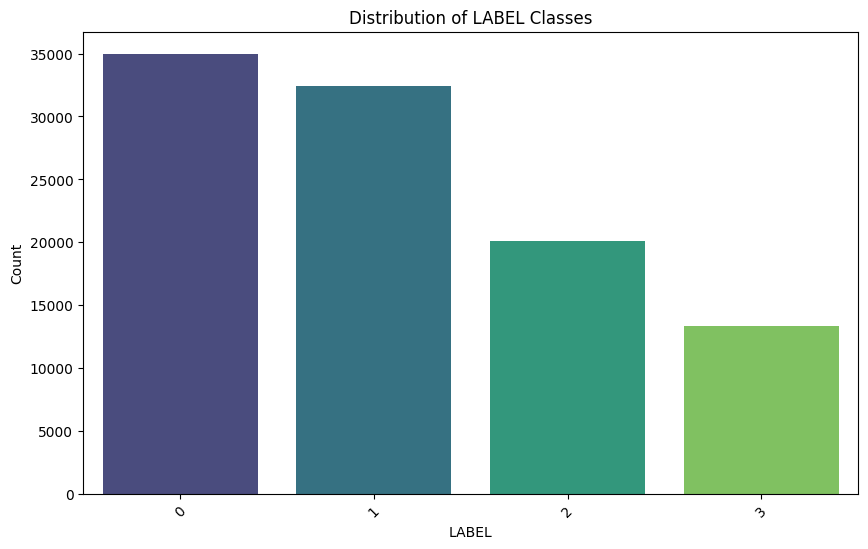

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
data = pd.read_csv("/kaggle/working/processed_data.csv")

# Plot the distribution of the LABEL column
plt.figure(figsize=(10, 6))
sns.countplot(data=data, x='LABEL', palette='viridis')
plt.title('Distribution of LABEL Classes')
plt.xlabel('LABEL')
plt.ylabel('Count')
plt.xticks(rotation=45)  # Rotate x labels for better readability
plt.show()


# Model Traning

---------------------------------

In [37]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from torch.utils.data import DataLoader, TensorDataset

# Load the dataset
data = pd.read_csv("/kaggle/working/processed_data.csv")

# Split data into features and labels
X = data.drop('LABEL', axis=1).values
y = data['LABEL'].values

# Normalize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_encoded, test_size=0.2, random_state=42)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)  # Using long for class indices
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Create DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)


In [36]:
class FeedForwardNet(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim=64):
        super(FeedForwardNet, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, output_dim)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)  # Output layer does not use activation function
        return x


In [38]:
# Initialize the model, loss function, and optimizer
input_dim = X_train.shape[1]  # Number of features
output_dim = len(label_encoder.classes_)  # Number of classes

model = FeedForwardNet(input_dim, output_dim)
criterion = nn.CrossEntropyLoss()  # Suitable for multi-class classification
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [39]:
# Training loop
epochs = 3
for epoch in range(epochs):
    model.train()  # Set the model to training mode
    total_loss = 0
    
    for inputs, targets in train_loader:
        optimizer.zero_grad()  # Clear gradients
        outputs = model(inputs)  # Forward pass
        loss = criterion(outputs, targets)  # Calculate loss
        loss.backward()  # Backpropagation
        optimizer.step()  # Update weights
        
        total_loss += loss.item()
    
    average_loss = total_loss / len(train_loader)
    
    # Print training progress
    print(f"Epoch {epoch + 1}/{epochs}, Loss: {average_loss:.4f}")


Epoch 1/3, Loss: 0.6485
Epoch 2/3, Loss: 0.5976
Epoch 3/3, Loss: 0.5852


In [40]:
def evaluate_accuracy(model, X_test_tensor, y_test_tensor):
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        outputs = model(X_test_tensor)  # Get model outputs
        _, predicted = torch.max(outputs, dim=1)  # Get predicted classes
        accuracy = (predicted == y_test_tensor).float().mean()  # Calculate accuracy
    return accuracy.item()

# Calculate accuracy on the test set
accuracy = evaluate_accuracy(model, X_test_tensor, y_test_tensor)
print(f"Test Accuracy: {accuracy * 100:.2f}%")


Test Accuracy: 74.36%
